## DEV Bounding box augmentation for the Roboflow data set ##

In [10]:
import os
import sys
import glob
import logging
import json
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import cv2

import albumentations as alb

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

from transformers import RTDetrImageProcessor

%load_ext autoreload
%autoreload 2
import computervision
from computervision.dentex import Dentex
from computervision.imageproc import ImageData, yolo2xywh, clipxywh, is_image
from computervision.transformations import AugmentationTransform
from computervision.datasets import DETRdataset

# Print version info
print(f'Package version: {computervision.__version__}')
print(f'Python version:  {sys.version}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Package version: v0.0.2
Python version:  3.12.3 (main, Jun 18 2025, 17:59:45) [GCC 13.3.0]


In [2]:
data_dir = os.environ.get('DATA')
print(f'data_dir: {data_dir}')
image_dir = os.path.join(data_dir, 'dataset_object_roboflow_240930')

data_dir: /app/data_model


## Load the annotations ##

In [27]:
parquet_file_name = 'roboflow_240930.parquet'
parquet_file = os.path.join(image_dir, parquet_file_name)
try:
    df = pd.read_parquet(parquet_file)
except Exception as e:
    print(f'ERROR: Could not load file: \n {e}')
    print('Make sure to run the first notebook which downloads the data.')

file_col = 'multi_file'
bbox_col = 'bbox'
pos_col = 'pos'

# Let's get the data with the position information
print(df.shape[0])
df = df.loc[~df[pos_col].isnull()].astype({pos_col: int})
print(df.shape[0])
print(len(df[file_col].unique()))
display(df.head(5))

12559
8788
991


,id,license,file_name,height,width,date_captured,file_name_hash,dset,multi_file,bbox,category,disease,pos,box_id
1,0,1,pbws-super-set-1-completed__PBWs_Super_Set_2-0...,480,640,2024-09-17T23:44:33+00:00,40762886f4,train,40762886f4.jpg,"[8.0, 0.0, 130.293, 176.736]",tooth 23,teeth,11,40762886f4_1
2,0,1,pbws-super-set-1-completed__PBWs_Super_Set_2-0...,480,640,2024-09-17T23:44:33+00:00,40762886f4,train,40762886f4.jpg,"[130.0, 0.0, 258.408, 186.778]",tooth 25,teeth,13,40762886f4_2
3,0,1,pbws-super-set-1-completed__PBWs_Super_Set_2-0...,480,640,2024-09-17T23:44:33+00:00,40762886f4,train,40762886f4.jpg,"[258.0, 0.0, 438.382, 192.803]",tooth 26,teeth,14,40762886f4_3
4,0,1,pbws-super-set-1-completed__PBWs_Super_Set_2-0...,480,640,2024-09-17T23:44:33+00:00,40762886f4,train,40762886f4.jpg,"[436.0, 1.0, 607.21, 185.77]",tooth 27,teeth,15,40762886f4_4
5,0,1,pbws-super-set-1-completed__PBWs_Super_Set_2-0...,480,640,2024-09-17T23:44:33+00:00,40762886f4,train,40762886f4.jpg,"[5.0, 207.0, 79.395, 473.109]",tooth 33,teeth,22,40762886f4_5


In [28]:
# Let's make sure that we have the expected number of images available
# If the image numbers don't match, please run the first three notebooks.

file_list = [os.path.join(image_dir, file) for file in df[file_col].unique()]
checked = np.sum([is_image(file) for file in file_list])

print(f'Expected images: {len(file_list)}')
print(f'Checked images:  {checked}')

# We want to be sure that the number of images is correct before we continue
assert checked == len(file_list), \
    f'WARNING: expected images ({expected_images}) != images on file system ({len(file_list)})'

Expected images: 991
Checked images:  991


In [29]:
# Function to plot an image with the bounding boxes
def plot_boxes(image, box_list, ax, label_list=None, color=None, cmap='grey'):
    offset_xy = (10, 100)
    # Take a ratio that looks good
    offset = (image.shape[1]*offset_xy[0]/2500,
              image.shape[0]*offset_xy[1]/1250)
    if color is None:
        # If no color is provided, color each box in a different color
        color_list = list(plt.cm.rainbow(np.linspace(0, 1, len(box_list))))
    else:
        color_list = [color]*len(box_list)
    ax.set(xticks=[], yticks=[])
    ax.imshow(image, cmap=cmap)
    # Loop over the bounding boxes
    for b, box in enumerate(box_list):
        rect = Rectangle(xy=(box[0], box[1]),
                         width=box[2],
                         height=box[3],
                         linewidth=1.5,
                         edgecolor=color_list[b],
                         facecolor='none',
                         alpha=0.7)
        ax.add_patch(rect)
        if label_list is not None:
            ax.text(x=box[0]+offset[0], y=box[1]+offset[1], s=label_list[b], color=color_list[b], fontsize=8)
    return ax

### Augmenting bounding boxes ###

In [68]:
im_size = 640
im_width = im_size
im_height = im_size

train_crop_transforms = [alb.NoOp()]

train_image_transforms = [
    alb.Affine(translate_percent=(-0.01, 0.01),
               rotate=(-15, 15),
               interpolation=cv2.INTER_LINEAR,
               border_mode=cv2.BORDER_CONSTANT,
               keep_ratio=True,
               rotate_method='largest_box',
               balanced_scale=True,
               p=1.0),
    alb.CoarseDropout(num_holes_range=(1, 32),
                      hole_height_range=(4, 50),
                      hole_width_range=(4, 50),
                      p=1.0),
    alb.RandomBrightnessContrast(p=1.0),
    alb.Sharpen(p=1.0),
    alb.CLAHE(p=1.0)]

train_transforms = train_crop_transforms + train_image_transforms

# Validation transforms
val_crop_transforms = [alb.NoOp(p=1)]
val_image_transforms = [alb.AutoContrast(p=1), alb.CLAHE(p=1)]

val_transforms = val_crop_transforms + val_image_transforms

# Add the bounding box format to the dataset class
bbox_format = {'format': 'coco',
               'label_fields': ['tooth_position'],
               'clip': True,
               'min_area': 10000}

processor_params = {'do_resize': True,
                    'size': {'max_height': im_size,
                             'max_width': im_size},
                    'do_pad': True,
                    'pad_size': {'height': im_size,
                                 'width': im_size}}
# Image processor
model_checkpoint = 'PekingU/rtdetr_v2_r101vd'
image_processor = RTDetrImageProcessor.\
    from_pretrained(model_checkpoint, **processor_params)

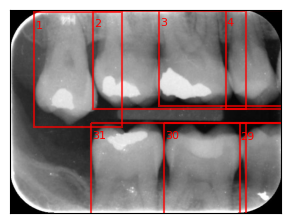

(480, 640, 3)
OUTPUT 1 / 10


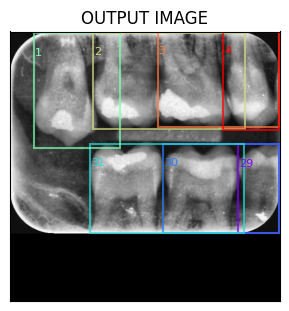

OUTPUT 2 / 10


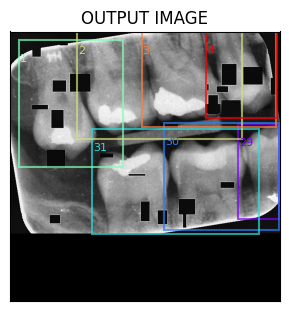

OUTPUT 3 / 10


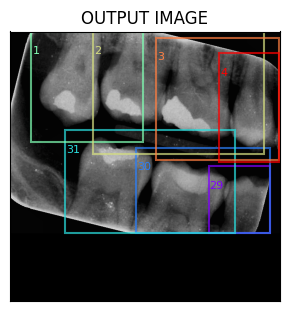

OUTPUT 4 / 10


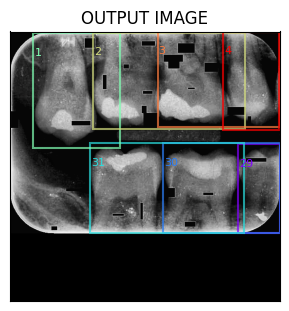

OUTPUT 5 / 10


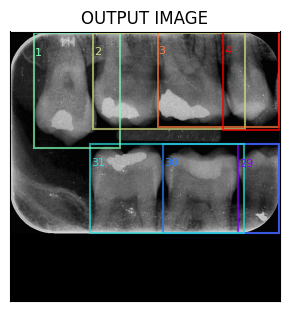

OUTPUT 6 / 10


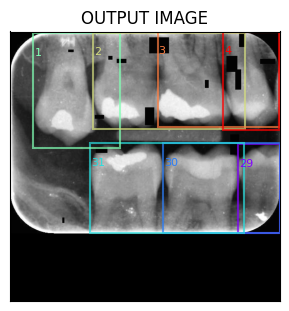

OUTPUT 7 / 10


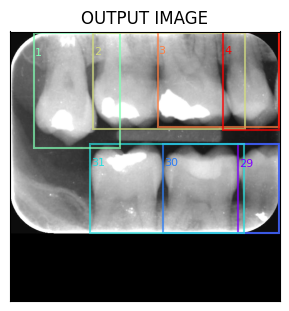

OUTPUT 8 / 10


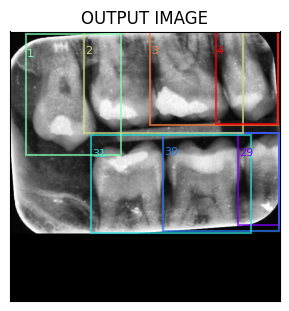

OUTPUT 9 / 10


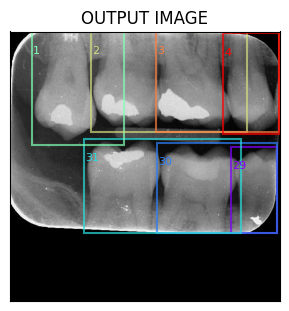

OUTPUT 10 / 10


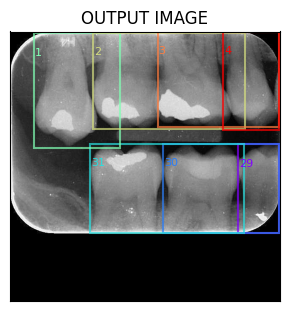

In [73]:
# Take the transformation from the class
train_transforms = AugmentationTransform(im_width=im_width,
                                         im_height=im_height).\
    get_transforms(name='train_roboflow')

im_idx = 20
file_name_list = sorted(list(df[file_col].unique()))
file_name = file_name_list[im_idx]

file_df = df.loc[df[file_col]==file_name] 

file = os.path.join(image_dir, file_name)
im = ImageData().load_image(file)
im = ImageData().np2color(im)
bbox_list = file_df[bbox_col].tolist()
label_list = file_df[pos_col].tolist()

# Dataset
dataset = DETRdataset(data=file_df,
                      image_processor=image_processor,
                      image_dir=image_dir,
                      file_name_col=file_col,
                      label_id_col=pos_col,
                      bbox_col=bbox_col,
                      bbox_format=bbox_format,
                      transforms=train_transforms)
figsize = (3.5, 3.5)
fig, ax = plt.subplots(figsize=figsize)
ax = plot_boxes(image=im, box_list=bbox_list, label_list=label_list, ax=ax, color='r')
plt.show()
print(im.shape)

n_outputs = 10
for n in range(n_outputs):
    print(f'OUTPUT {n + 1} / {n_outputs}')
    output = dataset[0]
    proc_image_tensor = output.get('pixel_values')
    proc_image = np.transpose(proc_image_tensor.numpy(), (1, 2, 0))
    proc_annotation = output.get('labels')
    proc_size = list(proc_annotation.get('size').numpy().astype(int))
    proc_width, proc_height = int(proc_size[1]), int(proc_size[0])
    proc_labels = list(proc_annotation.get('class_labels').numpy())
    proc_boxes_yolo = list(proc_annotation.get('boxes').numpy())
    proc_boxes_xywh = [yolo2xywh(yolo_bbox=list(yolobox), 
                                 image_width=proc_width, 
                                 image_height=proc_height) for yolobox in proc_boxes_yolo] 
    proc_boxes_xywh = [clipxywh(box, xlim=[0, proc_width], ylim=[0, proc_height], decimals=0) for box in proc_boxes_xywh]
    fig, ax = plt.subplots(figsize=figsize)
    ax = plot_boxes(image=proc_image, box_list=proc_boxes_xywh, ax=ax, label_list=proc_labels)
    ax.set(title='OUTPUT IMAGE')
    plt.show()

IMAGE 1 / 10



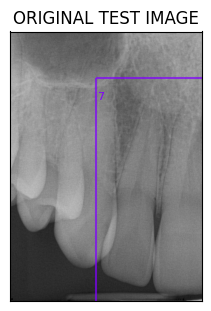

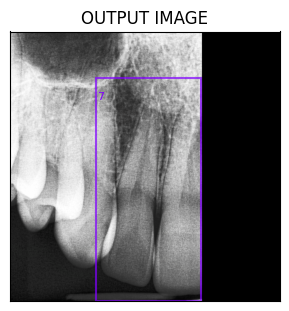

IMAGE 2 / 10



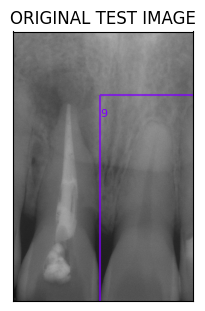

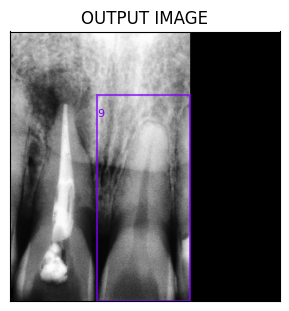

IMAGE 3 / 10



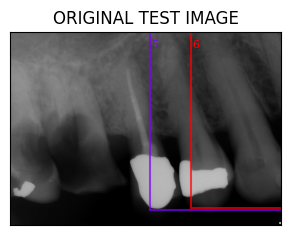

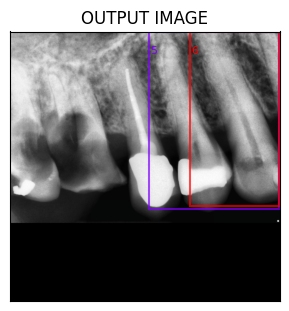

IMAGE 4 / 10



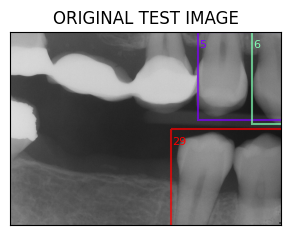

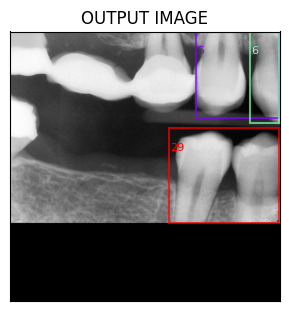

IMAGE 5 / 10



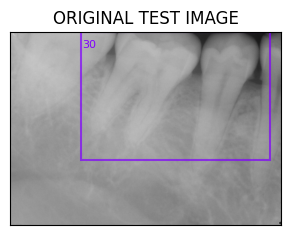

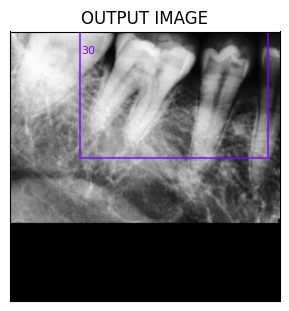

IMAGE 6 / 10



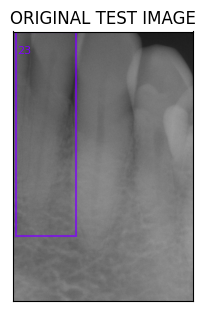

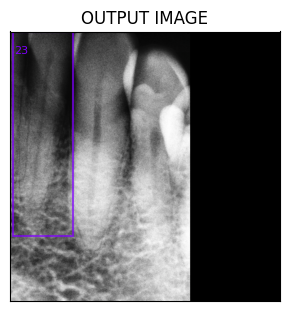

IMAGE 7 / 10



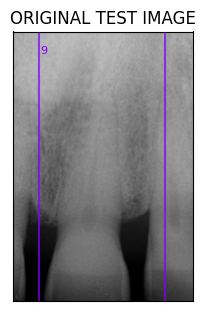

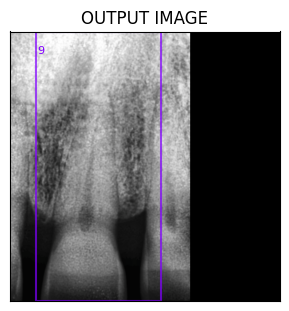

IMAGE 8 / 10



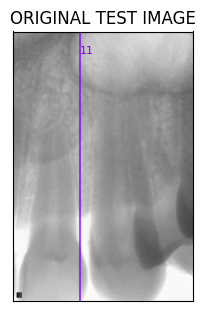

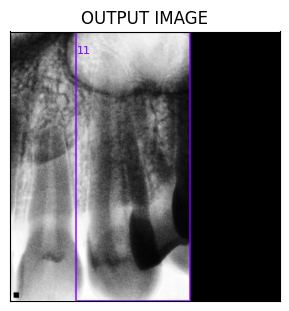

IMAGE 9 / 10



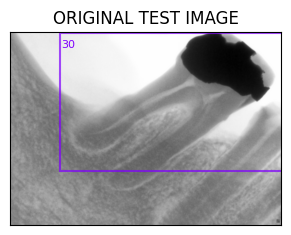

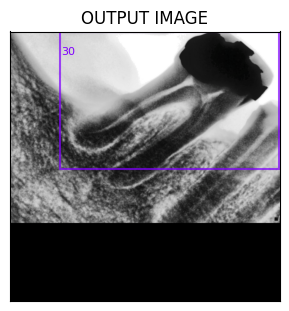

IMAGE 10 / 10



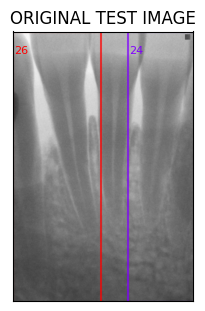

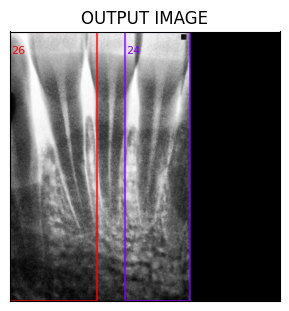

In [71]:
# Let's compare this with the input of the HMS test set
test_image_dir = os.path.join(data_dir, 'dataset_object_240921')
test_parquet_file_name = 'objectdata_240921_clean_ide.parquet'
test_parquet_file = os.path.join(test_image_dir, test_parquet_file_name)
test_df = pd.read_parquet(test_parquet_file)

seed_value = 123
rng = np.random.default_rng(seed_value)
multi_file_list = sorted(list(test_df['multi_file'].unique()))
multi_file_list_choice = rng.choice(multi_file_list, size=10, replace=False)

for m, multi_file_name in enumerate(multi_file_list_choice):

    print(f'IMAGE {m + 1} / {len(multi_file_list_choice)}')
    print()
    
    test_file = os.path.join(test_image_dir, multi_file_name)
    test_file_df = test_df.loc[test_df['multi_file'] == multi_file_name]
    im = ImageData().load_image(test_file)
    im = ImageData().np2color(im)
    bbox_list = test_file_df['bbox'].tolist()
    label_list = test_file_df['pos'].tolist()
    
    # Dataset
    test_dataset = DETRdataset(data=test_file_df,
                               image_processor=image_processor,
                               image_dir=test_image_dir,
                               file_name_col='multi_file',
                               label_id_col='pos',
                               bbox_col='bbox',
                               bbox_format=bbox_format,
                               transforms=val_transforms)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax = plot_boxes(image=im, box_list=bbox_list, label_list=label_list, ax=ax)
    ax.set(title='ORIGINAL TEST IMAGE')
    plt.show()

    # Show the output from the image processor
    output = test_dataset[0]
    proc_image_tensor = output.get('pixel_values')
    proc_image = np.transpose(proc_image_tensor.numpy(), (1, 2, 0))
    proc_annotation = output.get('labels')
    proc_size = list(proc_annotation.get('size').numpy().astype(int))
    proc_width, proc_height = int(proc_size[1]), int(proc_size[0])
    proc_labels = list(proc_annotation.get('class_labels').numpy())
    proc_boxes_yolo = list(proc_annotation.get('boxes').numpy())
    proc_boxes_xywh = [yolo2xywh(yolo_bbox=list(yolobox), 
                                 image_width=proc_width, 
                                 image_height=proc_height) for yolobox in proc_boxes_yolo] 
    proc_boxes_xywh = [clipxywh(box, xlim=[0, proc_width], ylim=[0, proc_height], decimals=0) for box in proc_boxes_xywh]
    fig, ax = plt.subplots(figsize=figsize)
    ax = plot_boxes(image=proc_image, box_list=proc_boxes_xywh, ax=ax, label_list=proc_labels)
    ax.set(title='OUTPUT IMAGE')
    plt.show()